# Digit Classification

## Dataset

Digit dataset with colorfull background , each class contain 2000 samples with dimension of 50x50 images.



In [ ]:
file_path='/white_text_s50.zip'

In [ ]:
from google.colab import drive
import zipfile
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to the ZIP file in Google Drive
zip_path = '/content/drive/My Drive'+file_path  # Update this path

# Step 3: Extract the ZIP file to /data directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

Mounted at /content/drive


In [1]:
data_dir = './output/white_text_s50'

In [2]:
import os
import random
from PIL import Image

def create_collage():
    # Define the collage size (10x10 grid, each image 50x50 pixels)
    collage_size = (50 * 10, 50 * 10)
    collage_image = Image.new('RGB', collage_size, (255, 255, 255))

    # Iterate over digit folders (0-9)
    for i in range(10):
        digit_dir = os.path.join(data_dir+'/', str(i))
        if os.path.exists(digit_dir):
            images = [os.path.join(digit_dir, f) for f in os.listdir(digit_dir) if f.endswith('.png')]

            if images:
                for j in range(10):
                    # Randomly select an image from the current digit folder
                    img_path = random.choice(images)
                    img = Image.open(img_path).resize((50, 50))

                    # Calculate position for the current image
                    position = (j * 50, i * 50)
                    collage_image.paste(img, position)

    return collage_image



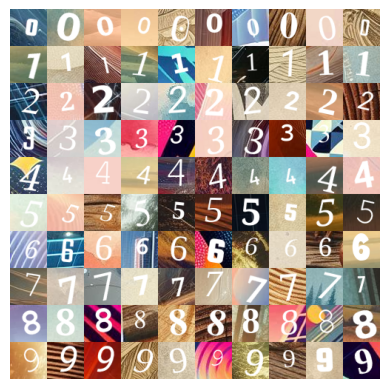

In [3]:
import matplotlib.pyplot as plt

collage_image = create_collage()
# save image
collage_image.save('collage.png')
# Display the collage using matplotlib
plt.imshow(collage_image)
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch

In [ ]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in subfolders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        # Collect all image paths and their corresponding labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
data_dir = './data/white_text_s50'
batch_size = 32
seed=42
train_split = 0.7
val_split = 0.15

## Splitting data into training and testing sets

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Define transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
# ])

# data_augmentation = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
#     transforms.RandomResizedCrop(224),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
transform = transforms.Compose([
    # transforms.Resize((50, 50)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = ImageFolderDataset(data_dir, transform=transform)


# Calculate lengths for splits
total_size = len(full_dataset)
train_size = int(train_split * total_size)
val_size = int(val_split * total_size)
test_size = total_size - train_size - val_size

# Split dataset
torch.manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0 # use 4 for training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

classes = full_dataset.classes
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 438
Validation batches: 94
Test batches: 94


In [ ]:
# Print the size of the augmented training dataset
print(f"Size of augmented training dataset: {len(train_dataset)}")

Size of augmented training dataset: 14000


In [ ]:
print("classes:",classes)

classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Bulding Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [ ]:
class DigitClassifier(nn.Module):
    def __init__(self, num_classes=10,dropout_rate=0.25):
        super(DigitClassifier, self).__init__()

        # Custom convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128*12*12, 1024),
            nn.ReLU(),
            nn.Dropout(0.15),


            nn.Linear(1024, num_classes)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv_layers(x)

        out = torch.flatten(out, 1)
        logits= self.fc_layers(out)
        return logits
        # return out

In [ ]:
model = DigitClassifier(num_classes=len(full_dataset.classes))
model.to(device)


DigitClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=18432, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
x = torch.randn(1, 3, 50, 50)
x = x.to(device)
print("input shape:",x.shape)
model(x).shape

input shape: torch.Size([1, 3, 50, 50])


torch.Size([1, 10])

In [ ]:
# using sample from the dataset
x,y = full_dataset[0]
print("x:",x.shape)
x = x.unsqueeze(0)
print("x in the batch",x.shape)
print("y value: ", y)

# crate one hot encoded vector for y
y_vect = torch.zeros(len(classes), dtype=torch.float32)
y_vect[y] = 1.0

x = x.to(device)
print("y_vect:",y_vect.shape)
logits = model(x)
print("prediction:",logits.shape)

prediction_vect = torch.softmax(logits, dim=1)
print("prediction_vect:",prediction_vect.shape)

predicted_label = torch.argmax(prediction_vect)
print("predicted_label:",predicted_label)

x: torch.Size([3, 50, 50])
x in the batch torch.Size([1, 3, 50, 50])
y value:  0
y_vect: torch.Size([10])
prediction: torch.Size([1, 10])
prediction_vect: torch.Size([1, 10])
predicted_label: tensor(0, device='cuda:0')


# Initialize model

In [ ]:
model = DigitClassifier(num_classes=len(full_dataset.classes))
model = model.to(device)

# Print model architecture

In [ ]:
#model.state_dict()

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_layers.0.weight 	 torch.Size([64, 3, 3, 3])
conv_layers.0.bias 	 torch.Size([64])
conv_layers.1.weight 	 torch.Size([64])
conv_layers.1.bias 	 torch.Size([64])
conv_layers.1.running_mean 	 torch.Size([64])
conv_layers.1.running_var 	 torch.Size([64])
conv_layers.1.num_batches_tracked 	 torch.Size([])
conv_layers.5.weight 	 torch.Size([128, 64, 3, 3])
conv_layers.5.bias 	 torch.Size([128])
conv_layers.6.weight 	 torch.Size([128])
conv_layers.6.bias 	 torch.Size([128])
conv_layers.6.running_mean 	 torch.Size([128])
conv_layers.6.running_var 	 torch.Size([128])
conv_layers.6.num_batches_tracked 	 torch.Size([])
fc_layers.0.weight 	 torch.Size([1024, 18432])
fc_layers.0.bias 	 torch.Size([1024])
fc_layers.3.weight 	 torch.Size([10, 1024])
fc_layers.3.bias 	 torch.Size([10])


In [ ]:
# Use Adam optimizer with L2 regularization (weight decay)
# optimizer = optim.Adam(
#     model.parameters(), lr=0.1, weight_decay=0.01
# )

optimizer = optim.Adam( model.parameters(), lr=0.01, weight_decay=0.01)


# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        batch_idx=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # print("input shape:", inputs.shape)
            # print("label shape:", labels.shape)
            # print("label:", labels)

            # Forward pass
            logits = model(inputs)
            # Calculate loss
            loss = criterion(logits, labels)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()

            prediction_vect = torch.softmax(logits, dim=1)
            # print("prediction_vect:",prediction_vect.shape)

            predicted_labels = torch.argmax(prediction_vect, dim=1)
            # print("predicted_labels:",predicted_labels.shape)
            # print("predicted_labels:",predicted_labels)
            # print("actual labels:",labels)

            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
            # print("correct:",correct)
            # print("total:",total)
            # Optional: Print batch progress
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            batch_idx+=1

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model(inputs)
                loss = criterion(logits, labels)

                running_loss += loss.item()

                prediction_vect = torch.softmax(logits, dim=1)
                predicted_labels = torch.argmax(prediction_vect, dim=1)

                total += labels.size(0)
                correct += (predicted_labels == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader)
        epoch_val_acc = 100. * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train the model
print("Starting training...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device=device
)


Starting training...
Epoch [1/30], Batch [100/438], Loss: 1.9723
Epoch [1/30], Batch [200/438], Loss: 1.0536
Epoch [1/30], Batch [300/438], Loss: 0.8539
Epoch [1/30], Batch [400/438], Loss: 0.7212

Epoch 1/30:
Train Loss: 6.6008, Train Acc: 56.04%
Val Loss: 1.1999, Val Acc: 67.97%
Epoch [2/30], Batch [100/438], Loss: 0.7173
Epoch [2/30], Batch [200/438], Loss: 0.5503
Epoch [2/30], Batch [300/438], Loss: 0.4410
Epoch [2/30], Batch [400/438], Loss: 0.5295

Epoch 2/30:
Train Loss: 0.5476, Train Acc: 82.39%
Val Loss: 0.6607, Val Acc: 85.47%
Epoch [3/30], Batch [100/438], Loss: 0.4531
Epoch [3/30], Batch [200/438], Loss: 0.4037
Epoch [3/30], Batch [300/438], Loss: 0.3144
Epoch [3/30], Batch [400/438], Loss: 0.7088

Epoch 3/30:
Train Loss: 0.4657, Train Acc: 85.23%
Val Loss: 0.4254, Val Acc: 85.80%
Epoch [4/30], Batch [100/438], Loss: 0.5472
Epoch [4/30], Batch [200/438], Loss: 0.7025
Epoch [4/30], Batch [300/438], Loss: 0.3119
Epoch [4/30], Batch [400/438], Loss: 0.3352

Epoch 4/30:
Train L

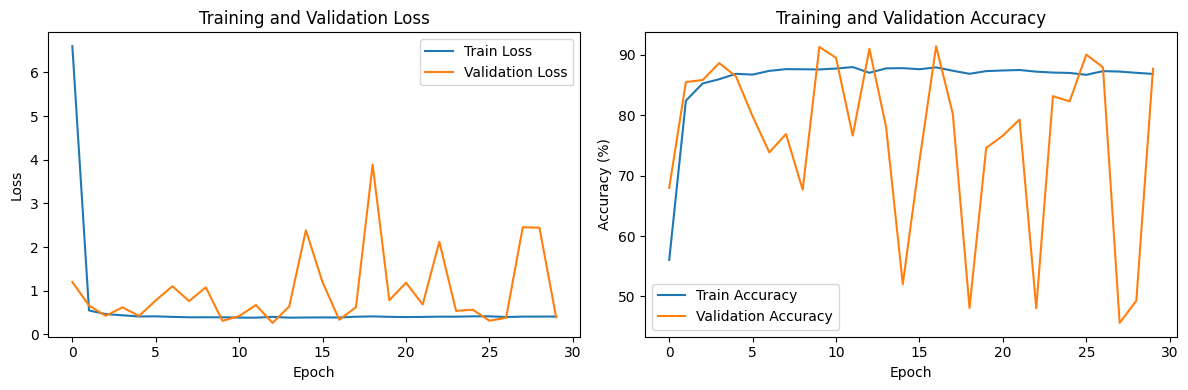

In [ ]:

# Plot training results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 0.88
Confusion Matrix:


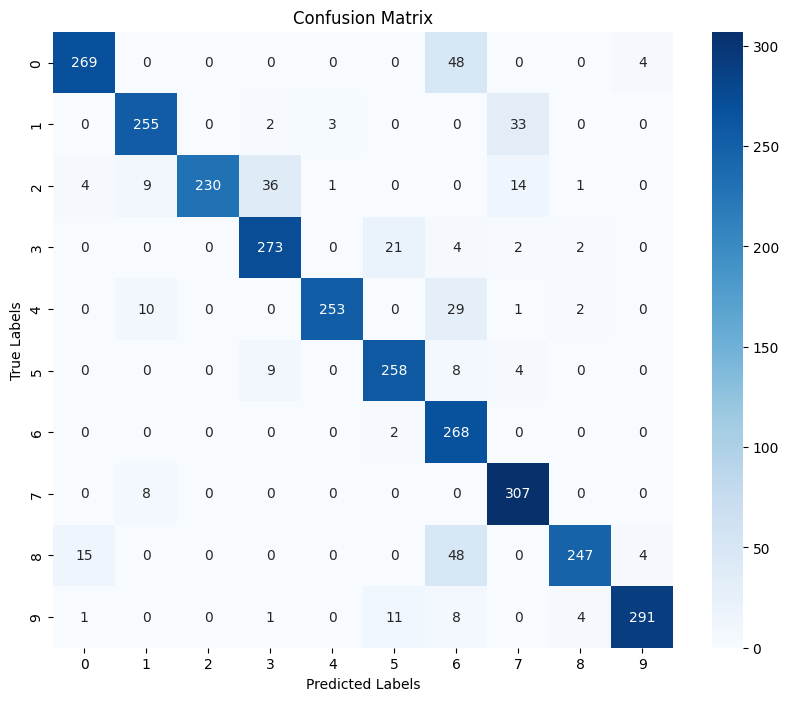

In [ ]:
# Inference script to test test_loader
def run_inference(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)
    softmax = nn.Softmax(dim=1)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probabilities = softmax(outputs)
            _, preds = torch.max(probabilities, 1)

            # Collect labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate and display the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


run_inference(model,test_loader,device)

# Precision and recall

# F1 Score

# Summary of error metrics